<a href="https://colab.research.google.com/github/silviasd2025-bit/dea_studies/blob/main/20250923_dea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq glpk-utils > /dev/null 2>&1

In [2]:
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                           SolverFactory, minimize, maximize, NonNegativeReals,
                           ConstraintList, TerminationCondition)
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import io
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Get the path to the glpsol executable
glpk_executable_path = '/usr/bin/glpsol'  # Update with the actual path if different

# Set the solver path in the SolverFactory call
solver = SolverFactory('glpk', executable=glpk_executable_path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#uploaded = files.upload()
file_path = "/content/drive/MyDrive/data/20250914_DEA_EnergySecurityPaper2.csv"
df = pd.read_csv(file_path)
df_2014 = df[df["year"] == 2014]
df_2022 = df[df["year"] == 2022]
df_2014[:20]

,Unnamed: 0,dmu,year,installed_capacity_per_capita,energy_diversification,energy_export,percentage_renewable,mwh_capita,gdp_capita,electrification,carbon_intensity,inverse_carbon_intensity
14,14,Argentina,2014,0.881,3794.220973,-14.067810,10.396,0.003288,12233.144412,100.0,424.13745,0.002358
38,38,Australia,2014,2.078,4460.109549,185.555789,5.663,0.010496,62544.087377,100.0,734.18134,0.001362
62,62,Brazil,2014,0.544,4316.643494,-14.281473,37.566,0.002951,12274.993969,99.7,192.93880,0.005183
86,86,Canada,2014,3.908,3916.466444,66.764578,27.026,0.018324,50960.843117,100.0,188.86014,0.005295
110,110,China,2014,1.006,5615.278555,-17.557385,9.690,0.004175,7781.065975,100.0,693.72760,0.001441
134,134,EU27,2014,1.736,1881.543230,-63.669640,14.118,0.006375,35592.887488,100.0,369.34964,0.002707
158,158,France,2014,1.787,6092.567214,-47.903750,9.885,0.008754,43148.045929,100.0,52.19756,0.019158
182,182,Germany,2014,2.181,2518.528853,-64.035236,12.840,0.007604,48971.082472,100.0,521.68085,0.001917
206,206,India,2014,0.186,5829.264441,-36.565941,6.829,0.000962,1553.883961,85.1,741.50310,0.001349
230,230,Indonesia,2014,0.155,3382.223800,123.004442,4.708,0.000918,3441.068085,97.0,691.58880,0.001446


In [6]:
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

In [7]:
def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    print ("inputs")
    print (inputs)
    print ("norm_inputs")
    print (norm_inputs)

    print ("outputs")
    print (outputs)
    print ("norm_outputs")
    print (norm_outputs)

    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

In [19]:
def run_analysis(df, year_start, year_end):
  """
    Run the complete MPI analysis
  """
  # Initialize solver
  solver = SolverFactory('glpk', executable='/usr/bin/glpsol')


  # Split data by year


  input_cols = [
                #'energy_diversification',
                'energy_export',
                'percentage_renewable',
                'installed_capacity_per_capita',
                ]
  output_cols = [#'mwh_capita',
                 'gdp_capita',
                 'inverse_carbon_intensity']


  total_eff = []
  for year in range(year_start,year_end):

    print ("******************")
    print ("Year", year)
    print ("******************")

    df_year = df[df['year'] == year]

    inputs_year  = df_year[input_cols].values
    outputs_year = df_year[output_cols].values

    # Print data info
    print("\nData shapes:")
    print ("year", df_year)
    print(f"Year1 data: {df_year.shape}")

    print ("******************")
    print ("inputs_year")
    print (inputs_year)
    print ("\n******************")
    print ("outputs_year")
    print (outputs_year)

    #Calculate efficiencies
    print("\nCalculating period t efficiencies...")
    #print("inputs_t")
    #print(inputs_t)
    #print (dmu_indices)

    eff_t_t = calculate_efficiency_crs(inputs_year, outputs_year, inputs_year, outputs_year, solver, dmu_index=None)
    print ("eff_t_t")
    print (eff_t_t)
    print (type(eff_t_t))
    print (eff_t_t.shape)

    total_eff.append(eff_t_t)

  return total_eff

In [20]:
# Load data

df = pd.read_csv("/content/drive/MyDrive/data/20250914_DEA_EnergySecurityPaper2.csv")

year_start = 2000
year_end = 2024
total_eff = run_analysis(df,year_start, year_end)

df_year = df[df['year'] == 2000]
# Create results DataFrame
results = pd.DataFrame({
     'DMU': df_year['dmu'],
    })


n_years = year_end - year_start
#year_en = len(total_eff)
for i, year in zip(range(n_years), range(year_start,year_end)):
  print (i,year)
  results[year] = total_eff[i]
  print (total_eff[i])


print (results)
print (results.head())

Streaming output truncated to the last 5000 lines.
241             2807.872430     -85.433535                 7.295    0.004745   
265             2246.834134     -81.201668                 4.508    0.008511   
289             2862.169735      47.942933                 5.910    0.002100   
313             2777.290704      59.079652                 6.595    0.006100   
337             5012.182048     325.783228                 0.000    0.008573   
361             8839.069467      33.133822                 0.513    0.004417   
385             3239.546600     -87.872745                 0.293    0.006587   
409             3091.299926     -65.382773                 8.632    0.001845   
433             3087.726496      10.111062                 1.043    0.006490   
457             3375.827814     -28.915969                 3.287    0.013112   

       gdp_capita  electrification  carbon_intensity  inverse_carbon_intensity  
1     7141.475077        95.500000        302.085630               

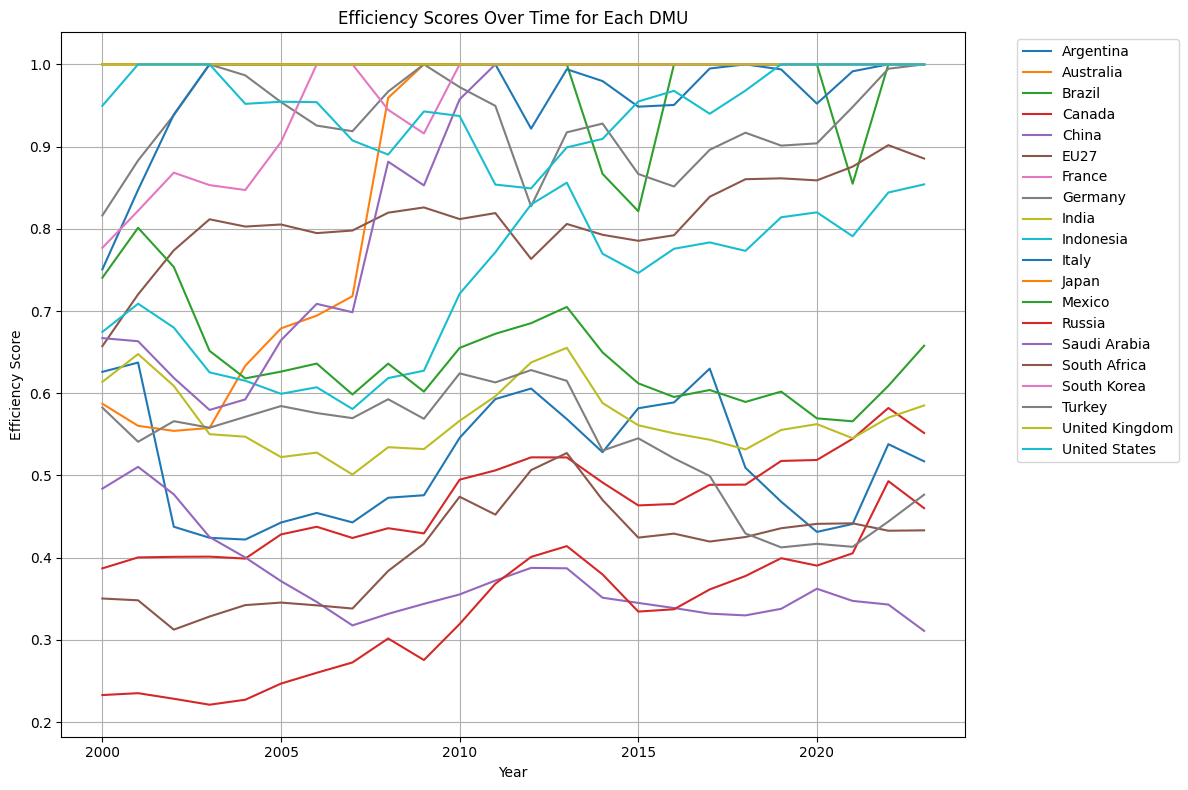

In [21]:
plt.figure(figsize=(12, 8))
for index, row in results.iterrows():
    dmu = row['DMU']
    efficiencies = row[results.columns[1:]].values  # Exclude 'DMU' column
    years = results.columns[1:]  # Exclude 'DMU' column
    #print(years)
    #print (efficiencies)
    plt.plot(years, efficiencies, label=dmu)

plt.xlabel('Year')
plt.ylabel('Efficiency Score')
plt.title('Efficiency Scores Over Time for Each DMU')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

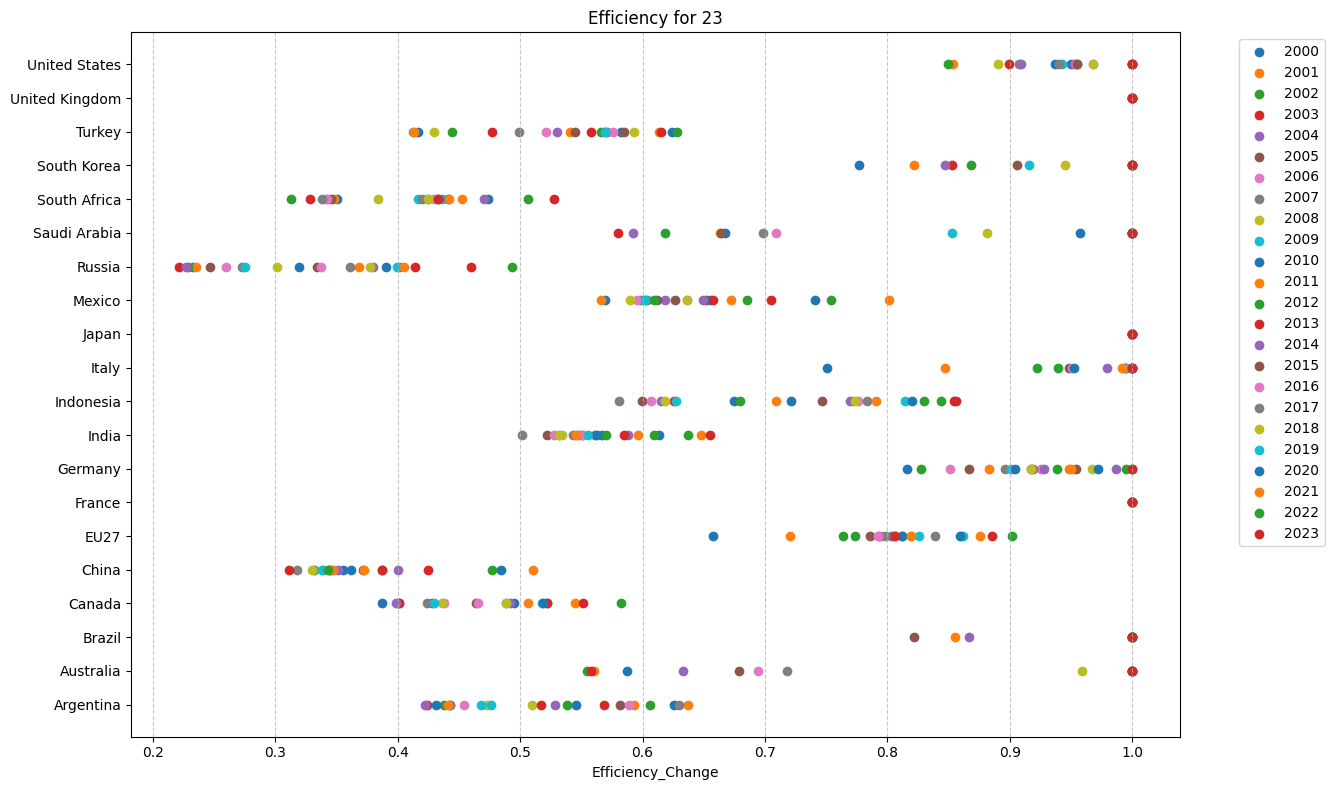

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

for year in range(2000,2024):
  # Create the figure and ax  is


  # Plot the mean EC points

  #print (results[year])
  #print(range(len(results)))

  ax.scatter(results[year], range(len(results)), label=str(year))

  # Plot the confidence intervals
  #for idx, row in df4.iterrows():
  #    ax.hlines(y=df4.index.get_loc(idx),
  #              xmin=row['Eff_CI_Lower'],
  #              xmax=row['Eff_CI_Upper'],
  #              color='blue',
  #              alpha=0.3)

  # Customize the plot
ax.set_yticks(range(len(results)))
ax.set_yticklabels(results['DMU'])
ax.set_xlabel('Efficiency_Change')
ax.set_title('Efficiency for %d')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()